In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.4.0
sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)
matplotlib 3.4.2
numpy 1.19.5
pandas 1.3.0
sklearn 0.24.2
tensorflow 2.4.0
tensorflow.keras 2.4.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [4]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [5]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.6860 - accuracy: 0.7650 - val_loss: 0.4307 - val_accuracy: 0.8414
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3927 - accuracy: 0.8574 - val_loss: 0.3758 - val_accuracy: 0.8696
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3569 - accuracy: 0.8724 - val_loss: 0.3468 - val_accuracy: 0.8768
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3319 - accuracy: 0.8805 - val_loss: 0.3311 - val_accuracy: 0.8804
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3100 - accuracy: 0.8884 - val_loss: 0.3333 - val_accuracy: 0.8774
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2936 - accuracy: 0.8934 - val_loss: 0.3167 - val_accuracy: 0.8910
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2748 - accuracy: 0.9018 - val_loss: 0.3136 - val_accuracy:

In [7]:
history.history

{'loss': [0.5284801721572876,
  0.38890621066093445,
  0.35163310170173645,
  0.32692140340805054,
  0.3082427978515625,
  0.2910606861114502,
  0.27873358130455017,
  0.26690489053726196,
  0.2563677132129669,
  0.2443360984325409],
 'accuracy': [0.8129090666770935,
  0.8615454435348511,
  0.8734727501869202,
  0.8818545341491699,
  0.8878909349441528,
  0.8945817947387695,
  0.8978000283241272,
  0.9030908942222595,
  0.9051636457443237,
  0.9101999998092651],
 'val_loss': [0.41287967562675476,
  0.37758299708366394,
  0.34666356444358826,
  0.3440593183040619,
  0.33389532566070557,
  0.3164125382900238,
  0.3079303205013275,
  0.3089417815208435,
  0.3067488670349121,
  0.2952997386455536],
 'val_accuracy': [0.8587999939918518,
  0.8636000156402588,
  0.873199999332428,
  0.8748000264167786,
  0.8754000067710876,
  0.8823999762535095,
  0.88919997215271,
  0.8912000060081482,
  0.8885999917984009,
  0.8912000060081482]}

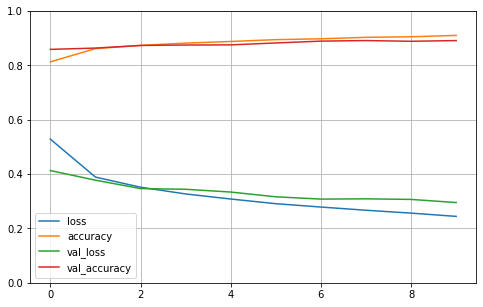

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [9]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3294 - accuracy: 0.8804


[0.32942697405815125, 0.8804000020027161]